In [1]:
import numpy as np
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import h5py
from noisi import WaveField
import json
from glob import glob
import os
from scipy.signal.signaltools import _next_regular
%matplotlib inline

In [2]:
######################
# Define the bases!
######################
# geography - Add anything else than a homogeneous distribution by setting to "True" the following:
only_ocean = False
gaussian_blobs = False
params_gaussian_blobs = [{'center':(0.,0.),'sigma_radius_m':500000.,'rel_weight':2.}]

#spectra
params_gaussian_spectra = [{'central_freq':0.005,'sigma_freq':0.01,'weight':0.01}]
                          #{'central_freq':0.075,'sigma_freq':0.1,'weight':10.}]

In [14]:
grd  = np.load('test_1/sourcegrid.npy')
ntraces = np.shape(grd)[-1]
print ntraces

565797


In [4]:
config = json.load(open('test_1/config.json'))
source_config = json.load(open('test_1/newsource/source_config.json'))
# Find the sampling rate and the nr. of points in synthetic seismograms
synthetics_path = config['wavefield_path']

if source_config['preprocess_do']:
    ext = '*.h5_proc'
else:
    ext = '*.h5'
print ext
wfs = glob(os.path.join(synthetics_path,ext))
with WaveField(wfs[0]) as wf:
    df = wf.stats['Fs']
    nt = wf.stats['nt']
    # The number of points for the fft is larger due to zeropadding --> apparent higher frequency sampling\n",
    n = _next_regular(2*nt-1)
    print df,nt,n
    freq = np.fft.rfftfreq(n,d=1./df)
    print np.min(freq),np.max(freq)
    taper = cosine_taper(len(freq),0.05)
    print len(freq)

*.h5_proc
<HDF5 file "testEQ.004.h5_proc" (mode r)>
0.4 7243 14580
0.0 0.2
7291


In [5]:
def get_distance(grid,location):
    def f(lat,lon,location):
        return abs(gps2dist_azimuth(lat,lon,location[0],location[1])[0])
    dist = np.array([f(lat,lon,location) for lat,lon in zip(grid[1],grid[0])])
    return dist
    # Use Basemap to figure out where ocean is
def get_ocean_mask():
    from mpl_toolkits.basemap import Basemap
    m = Basemap(rsphere=6378137,resolution='c',projection='cea',lat_0=0.,
                lon_0=0.,llcrnrlat=-90.,urcrnrlat=90.,llcrnrlon=-180.,urcrnrlon=180.)
    (x,y) = m(grd[0],grd[1])
    ocean_mask = map(lambda (x,y): not m.is_land(x,y),zip(x,y))
    return ocean_mask

In [19]:
#########################
# Create the source distr
#########################

# geography
num_bases = 1
if gaussian_blobs:
    num_bases += len(params_gaussian_blobs)

basis1 = np.zeros((num_bases,ntraces))
print np.shape(basis1)
# homogeneous layer
basis1[0,:] = np.ones(ntraces) 
if only_ocean:
    basis1[0,:] *= np.array(get_ocean_mask()).astype(int)
    # superimposed Gaussian blob(s)
if gaussian_blobs:
    i = 1
    for blob in params_gaussian_blobs:
        dist = get_distance(grd,blob['center'])
        basis1[i,:] = np.exp(-(dist)**2/(2*blob['sigma_radius_m']**2))
        i+=1

        
# spectra
basis2 = np.zeros((len(params_gaussian_spectra),len(freq)))
# 'sort of hum gaussian'
i = 0
for spec in params_gaussian_spectra:
    basis2[i,:] = taper*np.exp(-(freq-spec['central_freq'])**2/(2*spec['sigma_freq']**2))
# This normalization means different integrals...
    basis2[i,:] /= np.max(np.abs(basis2[0,:]))
    i+=1

print np.shape(basis1)

(1, 565797)
(1, 565797)


In [28]:
######################
# set the weights
#####################
# geography
weights1 = np.ones(np.shape(basis1)[0])
print np.shape(weights1)
if gaussian_blobs:
    i = 1
    for blob in params_gaussian_blobs:
        weights1[i] = blob['rel_weight']
        i+=1
#print weights1
# spectra --- much harder to assign manually, since we need weights for every location. just assigning ones.\n",
weights2 = np.ones((np.shape(grd)[-1],np.shape(basis2)[0]))
i=0
for spec in params_gaussian_spectra:
    weights2[:,i] *= spec['weight']
#print weights2

(1,)


In [29]:
from noisi.util import plot

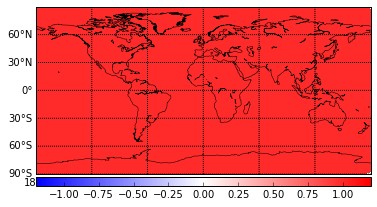

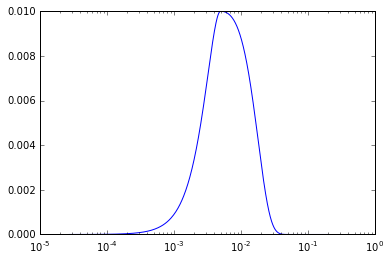

In [30]:
distr = np.dot(weights1,basis1)
plot.plot_grid(grd[0],grd[1],distr)

plt.semilogx(freq,np.dot(weights2[0,:],basis2))
plt.show()

In [31]:
# Save to an hdf5 file
print len(basis2[0,:])

with h5py.File('sourcemodel.h5','w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('frequencies',data=freq.astype(np.float32))
    fh.create_dataset('distr_basis',data=basis1.astype(np.float32))
    fh.create_dataset('distr_weights',data=weights1.astype(np.float32))
    fh.create_dataset('spect_basis',data=basis2.astype(np.float32))
    fh.create_dataset('spect_weights',data=weights2.astype(np.float32))


7291


In [32]:
ls

before_holidays.txt  PütheAbschied/               sourcemodel.h5
howto.docx           repaired_source_setup.ipynb  test_1/
Mukke/               sandbox_malwine/
